In [1]:
#import MPO_hyperparameter_v2
#import MPO_tt_v2
#import MPO_inference_v2
import MPO_train_v2_LeNet5 as MPO

from neural_networks import *

# Pre-processing

## 1. Train

In [4]:
D = 10
threshold = 90

In [5]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = MPO.main(r_1=D, r_2=D, r_3=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy at step 0: 0.122
Accuracy at step 1: 0.1246
Accuracy at step 2: 0.1249
Accuracy at step 3: 0.1288
Accuracy at step 4: 0.1294
Accuracy at step 5: 0.1304
Accuracy at step 12: 0.134
Accuracy at step 13: 0.1344
Accuracy at step 14: 0.1359
Accura

## 2. Open weights matrices into correct MPO

In [6]:
def weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site):
    """ Used specifically to convert the weights output by the MPO-Net networks into their MPO form

    Args:
        weights: List of weights matrices including biases
        sigma: List of input physical dimensions
        sigma_prime: List of output physical dimensions
        layer: Layer number (indexed from 0) such that we start at the correct weights matrix

    Returns:
        MPO: List of tensors corresponding to MPO of layer
        bias: Vector corresponding to the bias found in the list of weights
    """
    # Reshape weights, order of indices are an assumption and may need to be modified
    MPO = []
    num_sites = len(sigma)
    #starting_site = layer*(num_sites+1)  # +1 to skip bias

    for i in range(num_sites):
        # sigma'*D_right, D_left*sigma
        if i == 0:
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_right, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        elif i != 0 and i != num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, D, sigma[i]))
            # Need shape (D_left, D_right, sigma, sigma')
            site = np.transpose(site, (2, 1, 3, 0))
        elif i == num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_left, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        MPO.append(site)
    bias = weights[num_sites+starting_site]
    return MPO, bias

In [7]:
sigma = [2, 10, 10, 2]
sigma_prime = [2, 5, 6, 2]
MPO_0, bias_0 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=4)

In [8]:
sigma = [2, 5, 6, 2]
sigma_prime = [2, 3, 7, 2]
MPO_1, bias_1 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=9)

In [9]:
sigma = [2, 3, 7, 2]
sigma_prime = [1, 5, 2, 1]
MPO_2, bias_2 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=14)

In [10]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [11]:
def LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2):
    """ Recreation of the FC2 network

    Args:
        MPO_0: List of tensors corresponding to MPO of 0th layer
        bias_0: Vector corresponding to bias of 0th layer
        MPO_1: List of tensors corresponding to MPO of 0th layer
        bias_1: Layer number (indexed from 0) such that we start at the correct weights matrix

    Returns:
        acc: Accuracy on test set
        t: Time to contract all layers
    """
    data = input_data.read_data_sets("./data/", validation_size=0, one_hot=True)

    start = time.time()


    for i in range(len(MPO_0)-1):
        if i == 0:
            layer_0 = con.contract_horizontal(MPO_0[i], MPO_0[i+1], 'right')
        else:
            layer_0 = con.contract_horizontal(layer_0, MPO_0[i+1], 'right')

    for i in range(len(MPO_1)-1):
        if i == 0:
            layer_1 = con.contract_horizontal(MPO_1[i], MPO_1[i+1], 'right')
        else:
            layer_1 = con.contract_horizontal(layer_1, MPO_1[i+1], 'right')

    for i in range(len(MPO_2)-1):
        if i == 0:
            layer_2 = con.contract_horizontal(MPO_2[i], MPO_2[i+1], 'right')
        else:
            layer_2 = con.contract_horizontal(layer_2, MPO_2[i+1], 'right')

    end = time.time()

    total = 1000
    correct = 0        
    for i in range(0, total):
        # Must do this otherwise performance of inputs.eval() decays quickly
        # Massive speed up by reseting graph and session each time
        tf.compat.v1.reset_default_graph()
        with tf.compat.v1.Session() as sess:
            time0 = time.time()
            W_conv1 = weights[0]
            b_conv1 = weights[1]
            x_image = tf.reshape(data.test.images[i], [-1, 28, 28, 1])
            # 28x28x1
            h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
            # 28x28x6
            h_pool1 = max_pool_2x2(h_conv1)
            # 14x14x6
            W_conv2 = weights[2]
            b_conv2 = weights[3]
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            # 10x10x16
            h_pool2 = max_pool_2x2(h_conv2)
            # 5x5x16
            inputs = tf.reshape(h_pool2,[-1,400])
            out = inputs.eval()
            time1 = time.time()
            if i % 100 == 0:
                print(time1 - time0)
        xW = act.ReLU(out @ layer_0 + bias_0)
        xW = act.ReLU(xW @ layer_1 + bias_1)
        result = xW @ layer_2 + bias_2
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1
        
    acc = correct/total*100
    t = end-start
    return acc, t

In [12]:
acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
print(acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.011967897415161133
0.008977890014648438
0.00997471809387207
0.008998394012451172
0.010970592498779297
0.008974075317382812
0.00897669792175293
0.011967897415161133
0.008978605270385742
0.00997304916381836
90.10000000000001


## 4. Close legs to use for compression algorithm

In [13]:
MPS_0 = close_legs(MPO_0)
MPS_1 = close_legs(MPO_1)
MPS_2 = close_legs(MPO_2)

## 5. Compress MPS layers

In [14]:
compressed_MPS_0, dist, sim = compress_layer(MPS_0, phys_dim=[4, 50, 60, 4], threshold=1e-8, plot=0)
compressed_MPS_0.append(MPS_0)
compressed_MPS_1, dist, sim = compress_layer(MPS_1, phys_dim=[4, 15, 42, 4], threshold=1e-8, plot=0)
compressed_MPS_1.append(MPS_1)
compressed_MPS_2, dist, sim = compress_layer(MPS_2, phys_dim=[2, 15, 14, 2], threshold=1e-8, plot=0)
compressed_MPS_2.append(MPS_2)

Sim: 8.423957426835532 Dist: 11.786395597740885 BondDim: 1
Sim: 37.76284796476278 Dist: 10.468057634944437 BondDim: 2
Sim: 68.07167559919067 Dist: 8.903448939264521 BondDim: 3
Sim: 89.02955712839346 Dist: 7.636329058185471 BondDim: 4
Sim: 103.40077962968442 Dist: 6.6288987760861735 BondDim: 5
Sim: 116.32288924748272 Dist: 5.569577126299497 BondDim: 6
Sim: 125.20303038717711 Dist: 4.705321267044804 BondDim: 7
Sim: 133.457216090518 Dist: 3.726373910756051 BondDim: 8
Sim: 141.15403724134214 Dist: 2.4877784008908828 BondDim: 9
Sim: 12.343623457758113 Dist: 10.098397271734225 BondDim: 1
Sim: 43.570123722249676 Dist: 8.411368925048862 BondDim: 2
Sim: 66.91957724947657 Dist: 6.884887338660729 BondDim: 3
Sim: 83.69945413379978 Dist: 5.5336964844240955 BondDim: 4
Sim: 92.3693009188948 Dist: 4.685290812386412 BondDim: 5
Sim: 98.37342003073829 Dist: 3.993473536257513 BondDim: 6
Sim: 103.80726401248216 Dist: 3.242527856942064 BondDim: 7
Sim: 108.53163689882062 Dist: 2.4061616771752488 BondDim: 8
S

In [15]:
print("Orig:", calculate_params(MPS_0))
for i in range(len(compressed_MPS_0)):
    print(i+1, round(calculate_params(compressed_MPS_0[i])/calculate_params(MPS_0)*100, 2), "% of Orig")

Orig: 11080
1 1.06 % of Orig
2 4.12 % of Orig
3 9.15 % of Orig
4 16.17 % of Orig
5 20.14 % of Orig
6 24.12 % of Orig
7 28.09 % of Orig
8 32.06 % of Orig
9 36.03 % of Orig
10 100.0 % of Orig


In [16]:
print("Orig:", calculate_params(MPS_1))
for i in range(len(compressed_MPS_1)):
    print(i+1, round(calculate_params(compressed_MPS_1[i])/calculate_params(MPS_1)*100, 2), "% of Orig")

Orig: 5780
1 1.12 % of Orig
2 4.22 % of Orig
3 9.29 % of Orig
4 16.33 % of Orig
5 20.28 % of Orig
6 24.22 % of Orig
7 28.17 % of Orig
8 32.11 % of Orig
9 36.06 % of Orig
10 100.0 % of Orig


In [17]:
print("Orig:", calculate_params(MPS_2))
for i in range(len(compressed_MPS_2)):
    print(i+1, round(calculate_params(compressed_MPS_2[i])/calculate_params(MPS_2)*100, 2), "% of Orig")

Orig: 2940
1 1.12 % of Orig
2 4.22 % of Orig
3 6.19 % of Orig
4 8.16 % of Orig
5 10.14 % of Orig
6 12.11 % of Orig
7 14.08 % of Orig
8 16.05 % of Orig
9 18.03 % of Orig
10 100.0 % of Orig


# Accuracy Tests

## 1. Check accuracy for each compressed dimension

In [18]:
def test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0_orig, bias_0, MPO_1_orig, bias_1, MPO_2_orig, bias_2, sigma_0, sigma_1, sigma_2, sigma_3, layer):
    acc_compressed = []
    time_compressed = []
    params = []



    for new_dim in range(1, len(compressed_MPS_0)+1):
        if layer == 0:
            MPS_0 = compressed_MPS_0[new_dim-1]
            MPS_1 = compressed_MPS_1[-1]
            MPS_2 = compressed_MPS_2[-1]
        elif layer == 1:
            MPS_0 = compressed_MPS_0[-1]
            MPS_1 = compressed_MPS_1[new_dim-1]
            MPS_2 = compressed_MPS_2[-1]
        elif layer == 2:
            MPS_0 = compressed_MPS_0[-1]
            MPS_1 = compressed_MPS_1[-1]
            MPS_2 = compressed_MPS_2[new_dim-1]

        dim_0 = [MPS_0[0].shape[1], MPS_0[1].shape[1], MPS_0[2].shape[1], MPS_0[3].shape[1]]
        dim_1 = [MPS_1[0].shape[1], MPS_1[1].shape[1], MPS_1[2].shape[1], MPS_1[3].shape[1]]
        dim_2 = [MPS_2[0].shape[1], MPS_2[1].shape[1], MPS_2[2].shape[1], MPS_2[3].shape[1]]
        MPO_0 = open_legs(MPS_0, sigma_0, sigma_1, bond_dim=dim_0)
        MPO_1 = open_legs(MPS_1, sigma_1, sigma_2, bond_dim=dim_1)
        MPO_2 = open_legs(MPS_2, sigma_2, sigma_3, bond_dim=dim_2)

        total_params = 0
        for tensor in MPO_0:
            total_params += tensor.size
        for tensor in MPO_1:
            total_params += tensor.size
        for tensor in MPO_2:
            total_params += tensor.size
        params.append(total_params)

        acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
        acc_compressed.append(acc)
        time_compressed.append(t)

    params_orig = 0
    for tensor in MPO_0_orig:
        params_orig += tensor.size
    for tensor in MPO_1_orig:
        params_orig += tensor.size
    for tensor in MPO_2_orig:
        params_orig += tensor.size

    params = np.array(params)/params_orig*100
    acc_orig, time_orig = LeNet5(MPO_0_orig, bias_0, MPO_1_orig, bias_1, MPO_2_orig, bias_2)

    x = range(1, len(compressed_MPS_0)+1)
    data1 = acc
    data2 = params

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Compressed Dimension')
    ax1.set_ylabel('Accuracy [%]', color=color)
    ax1.plot(x, acc_compressed, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(acc_orig, color='r', linestyle='--')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, params, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)))

    fig.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(x, time_compressed)
    plt.title('Contraction Time vs. Compressed Dimension')
    plt.xlabel('Time [s]')
    plt.ylabel('Compressed Dimension')
    plt.axhline(time_orig, color='r', linestyle='--')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.012973308563232422
0.011970758438110352
0.00997304916381836
0.010970592498779297
0.009975910186767578
0.009975194931030273
0.012964725494384766
0.011966943740844727
0.014042139053344727
0.013962507247924805
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.013961315155029297
0.023935794830322266
0.027924776077270508
0.01196432113647461
0.009974956512451172
0.012954235076904297
0.011968851089477539
0.010970115661621094
0.01196742057800293
0.011015176773071289
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.01197195053100586
0.01296854019165039
0.0109736

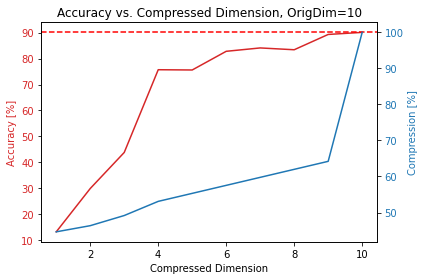

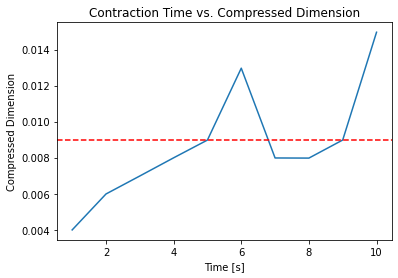

In [19]:
sigma_0 = [2, 10, 10, 2]
sigma_1 = [2, 5, 6, 2]
sigma_2 = [2, 3, 7, 2]
sigma_3 = [1, 5, 2, 1]
test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2, sigma_0, sigma_1, sigma_2, sigma_3,
                             layer=0)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.010480165481567383
0.00997304916381836
0.011967897415161133
0.00997304916381836
0.009972095489501953
0.009976625442504883
0.010973215103149414
0.010979890823364258
0.01097416877746582
0.009974002838134766
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.013962507247924805
0.011967182159423828
0.011968135833740234
0.010971307754516602
0.009975194931030273
0.009974241256713867
0.009975910186767578
0.00995945930480957
0.009976387023925781
0.010972023010253906
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.009974002838134766
0.009977579116821289
0.010507

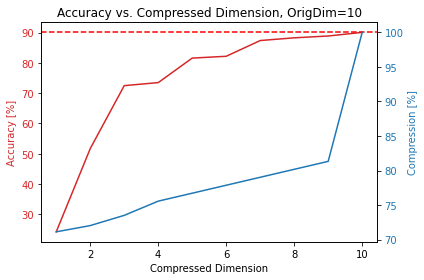

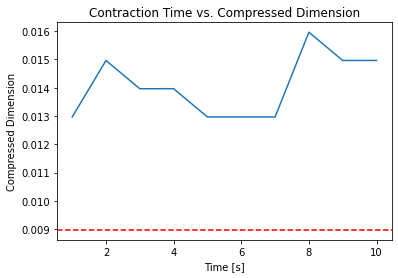

In [20]:
test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2, sigma_0, sigma_1, sigma_2, sigma_3,
                             layer=1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.011967897415161133
0.010999202728271484
0.010970115661621094
0.01296854019165039
0.011577129364013672
0.009973287582397461
0.010970830917358398
0.009972572326660156
0.010993003845214844
0.008976459503173828
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.00997304916381836
0.009975194931030273
0.008948326110839844
0.009978055953979492
0.009972572326660156
0.010482549667358398
0.010071516036987305
0.00997304916381836
0.008976221084594727
0.009975433349609375
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.008975505828857422
0.00899052619934082
0.009974

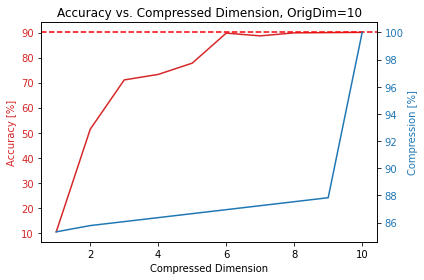

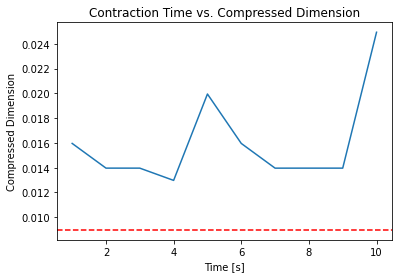

In [21]:
test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2, sigma_0, sigma_1, sigma_2, sigma_3,
                             layer=2)

In [22]:
def compress_layer_single_dim(raw_state, phys_dim, threshold, compressed_dim, compressed_state=0, plot=0):
    """ Initializes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

        Note: Does NOT normalize the state unlike the compression function
              found in compression.py

    Args:
        raw_state: MPS to be compressed
        phys_dim: List of physical dimensions by site
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
                          otherwise a random MPS is ini
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    compressed_state = init.initialize_random_MPS_with_changing_phys_dim(phys_dim,
                                                                         num_sites=len(raw_state),
                                                                         bond_dim=compressed_dim)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.scalar_product(compressed_state, raw_state))
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.scalar_product(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            #best_dist.append((metrics.overlap(compressed_state, raw_state)))
            #best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", sim[-1], "Dist:", dist[-1], "BondDim:", compressed_dim)
            #compressions.append(compressed_state[:])
            break

    return compressed_state, dist, sim


In [23]:
### Optimized path
# 1. Starting state
# 2. Compress all layers down by 1
# 3. Calculate delta_params in all directions
# 4. Calculate delta_acc in all directions
# 5. Moved based on minimizing delta_acc/delta_params

sigma_0 = [2, 10, 10, 2]
sigma_1 = [2, 5, 6, 2]
sigma_2 = [2, 3, 7, 2]
sigma_3 = [1, 5, 2, 1]

MPO_0, bias_0 = weights_to_MPO_mod(weights, D, sigma_0, sigma_1, starting_site=4)
MPO_1, bias_1 = weights_to_MPO_mod(weights, D, sigma_1, sigma_2, starting_site=9)
MPO_2, bias_2 = weights_to_MPO_mod(weights, D, sigma_2, sigma_3, starting_site=14)
layers = [MPO_0, MPO_1, MPO_2]

acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
threshold = 90
last_updated = np.ones(len(layers))
while True:
    print(acc)
    # 1. Starting state
    MPS_0 = close_legs(layers[0])
    MPS_1 = close_legs(layers[1])
    MPS_2 = close_legs(layers[2])

    # 2. Compress all layers down by 1
    dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
    dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]
    dim2 = MPS_2[math.ceil(len(MPS_1)/2)].shape[0]

    if last_updated[0] == 1:
        compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[4,50,60,4], threshold=1e-6, compressed_dim=dim0-1)
        bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
        new_MPO_0 = open_legs(compressed_0, sigma=sigma_0, sigma_prime=sigma_1, bond_dim=bonds0)
    if last_updated[1] == 1:
        compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,15,42,4], threshold=1e-6, compressed_dim=dim1-1)
        bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
        new_MPO_1 = open_legs(compressed_1, sigma=sigma_1, sigma_prime=sigma_2, bond_dim=bonds1)
    if last_updated[2] == 1:
        compressed_2, _, _ = compress_layer_single_dim(MPS_2, phys_dim=[2,15,14,2], threshold=1e-6, compressed_dim=dim2-1)
        bonds2 = [compressed_2[0].shape[1], compressed_2[1].shape[1], compressed_2[2].shape[1], compressed_2[3].shape[1]]
        new_MPO_2 = open_legs(compressed_2, sigma=sigma_2, sigma_prime=sigma_3, bond_dim=bonds2)
    MPOs = [new_MPO_0, new_MPO_1, new_MPO_2]

    # 3. Calculate delta_params
    delta_params0 = calculate_params(MPO_0) - calculate_params(new_MPO_0)
    delta_params1 = calculate_params(MPO_1) - calculate_params(new_MPO_1)
    delta_params2 = calculate_params(MPO_2) - calculate_params(new_MPO_2)

    # 4. Calculate delta_acc
    new_acc0, _ = LeNet5(new_MPO_0, bias_0, layers[1], bias_1, layers[2], bias_2)
    new_acc1, _ = LeNet5(layers[0], bias_0, new_MPO_1, bias_1, layers[2], bias_2)
    new_acc2, _ = LeNet5(layers[0], bias_0, layers[1], bias_1, new_MPO_2, bias_2)

    new_acc = [new_acc0, new_acc1, new_acc2]
    print(new_acc)
    delta_acc0 = acc - new_acc0
    delta_acc1 = acc - new_acc1
    delta_acc2 = acc - new_acc2

    # 5. Calculate slope
    slope = [delta_acc0/delta_params0, delta_acc1/delta_params1, delta_acc2/delta_params2]
    for i, acc in enumerate(new_acc):
        if acc < threshold:
            slope[i] = np.inf
        
    # 6. Find minimum slope
    index = np.argmin(slope)

    # 7. Update layers
    if new_acc0 < threshold and new_acc1 < threshold and new_acc2 < threshold:
        break
    else:
        layers[index] = MPOs[index]
        acc = new_acc[index]
        last_updated = np.zeros(len(layers))
        last_updated[index] = 1
        print(last_updated)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.011967658996582031
0.010970592498779297
0.010970592498779297
0.009974002838134766
0.00997614860534668
0.008977413177490234
0.009974479675292969
0.009975194931030273
0.009973287582397461
0.009973287582397461
90.10000000000001
Sim: 141.1540319663429 Dist: 2.487779461073339 BondDim: 9
Sim: 111.93707143479128 Dist: 1.5440788453754308 BondDim: 9
Sim: 61.971051833875016 Dist: 0.4921742777112828 BondDim: 9
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.011967658996582031
0.010046958923339844
0.00997304916381836
0.009972572326660156
0.009991884231567383
0.00997614860534668
0.009974002838134766
0.010739803314208984
0.009973764419555664
0.009973526000976562
Extracting ./data/train-images-

In [24]:
acc, _ = LeNet5(layers[0], bias_0, layers[1], bias_1, layers[2], bias_2)
print(acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.009978055953979492
0.00897526741027832
0.009973287582397461
0.009973287582397461
0.00997304916381836
0.009972333908081055
0.010978221893310547
0.010970115661621094
0.009974479675292969
0.009972572326660156
90.0


In [25]:
dim0 = layers[0][math.ceil(len(layers[0])/2)].shape[0]
dim1 = layers[1][math.ceil(len(layers[1])/2)].shape[0]
dim2 = layers[2][math.ceil(len(layers[2])/2)].shape[0]
print(dim0, dim1, dim2)

10 10 9


In [26]:
### Params compared to trained MPO model
orig_params = calculate_params(MPO_0) + calculate_params(MPO_1) + calculate_params(MPO_2)
params = calculate_params(layers[0]) + calculate_params(layers[1]) + calculate_params(layers[2])
print(round(params/orig_params*100, 2), "%")

87.83 %


In [27]:
### Params compared to typical model
orig_params = 400*120 + 120*88 + 88*10
params = calculate_params(layers[0]) + calculate_params(layers[1]) + calculate_params(layers[2])
print(round(params/orig_params*100, 2), "%")

29.26 %


In [65]:
### Permutations
# 1. Starting state
# 2. Compress single layer down until threshold
# 3. Switch layers

sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

layers = [MPO_0, MPO_1]

acc, _ = FC2(MPO_0, bias_0, MPO_1, bias_1)
threshold = 90
last_updated = np.ones(len(layers))

print(acc)
# 1. Starting state
MPS_0 = close_legs(layers[0])
MPS_1 = close_legs(layers[1])

# 2. Compress single layer down until acc less than threshold
dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]

layer_to_compress = 1
for i in range(len(layers)):
    if layer_to_compress == 0:
        while True:
            compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[16,28,28,16], threshold=1e-6, compressed_dim=dim0-1)
            bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
            new_MPO = open_legs(compressed_0, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=bonds0)
            new_acc, _ = FC2(new_MPO, bias_0, layers[1], bias_1)
            print(new_acc)
            if new_acc < threshold:
                layer_to_compress = 1
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim0 = dim0-1

    elif layer_to_compress == 1:
        while True:
            compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,40,4,4], threshold=1e-6, compressed_dim=dim1-1)
            bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
            new_MPO = open_legs(compressed_1, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=bonds1)
            new_acc, _ = FC2(layers[0], bias_0, new_MPO, bias_1)
            print(new_acc)
            if new_acc < threshold:
                layer_to_compress = 0
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim1 = dim1-1

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.87
Sim: 67.30286212970482 Dist: 0.015442028131288114 BondDim: 15
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.88
Sim: 67.30015369167334 Dist: 0.05428530431116446 BondDim: 14
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.88
Sim: 67.27090425430686 Dist: 0.1794333626465372 BondDim: 13
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.89
Sim: 67.20787210415153 Dist: 0.3085911239585396 BondDim: 12
Extracting ./data/tra

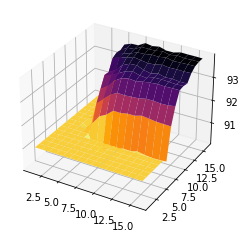

In [94]:
trimmed_acc = acc_matrix_plot[:]
trimmed_acc[acc_matrix_plot <= threshold] = threshold+1

fig = plt.figure()
ax = plt.gca(projection='3d')
x, y = np.meshgrid(np.arange(1,len(trimmed_acc)+1), np.arange(1,len(trimmed_acc[0])+1))
ax.plot_surface(x, y, trimmed_acc, cmap='inferno_r')

In [93]:
acc_matrix_plot

array([[90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.13, 90.38, 90.76, 90.68,
        90.81, 90.8 , 90.88, 90.82, 90.79, 90.79, 90.82],
       [90.  , 90.  , 90.  , 90.  , 91.32, 91.71, 91.87, 92.13, 92.12,
        92.18, 92.18, 92.2